In [19]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from pyvis.network import Network
import numpy as np
from tqdm import tqdm
import random

from networkx.algorithms.centrality import edge_betweenness_centrality

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool


from scipy.cluster.hierarchy import dendrogram

from wordcloud import WordCloud

import re
import plotly.graph_objects as go

import heapq
%matplotlib inline

In [2]:
# Définir le chemin de base
base_path = Path('Dataset') / 'wikipedia' / 'chameleon'

# Charger les données
with (base_path / 'musae_chameleon_features.json').open('r') as f:
    features = json.load(f)

edges = pd.read_csv(base_path / 'musae_chameleon_edges.csv')
targets = pd.read_csv(base_path / 'musae_chameleon_target.csv')

names = pd.read_csv('data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

In [3]:
names[0][3]

'3 LyndonHochschildSerre spectral sequence'

In [4]:
edges.head()

id1   id2
0  2034  1939
1  2034  2263
2  2034  1976
3  2034  2234
4  2034   804

In [5]:
targets.head()

id  target
0   0     171
1   1    8089
2   2    8568
3   3   47178
4   4    3634

Text(0.5, 1.0, 'Graphe construit à partir des données fournies')

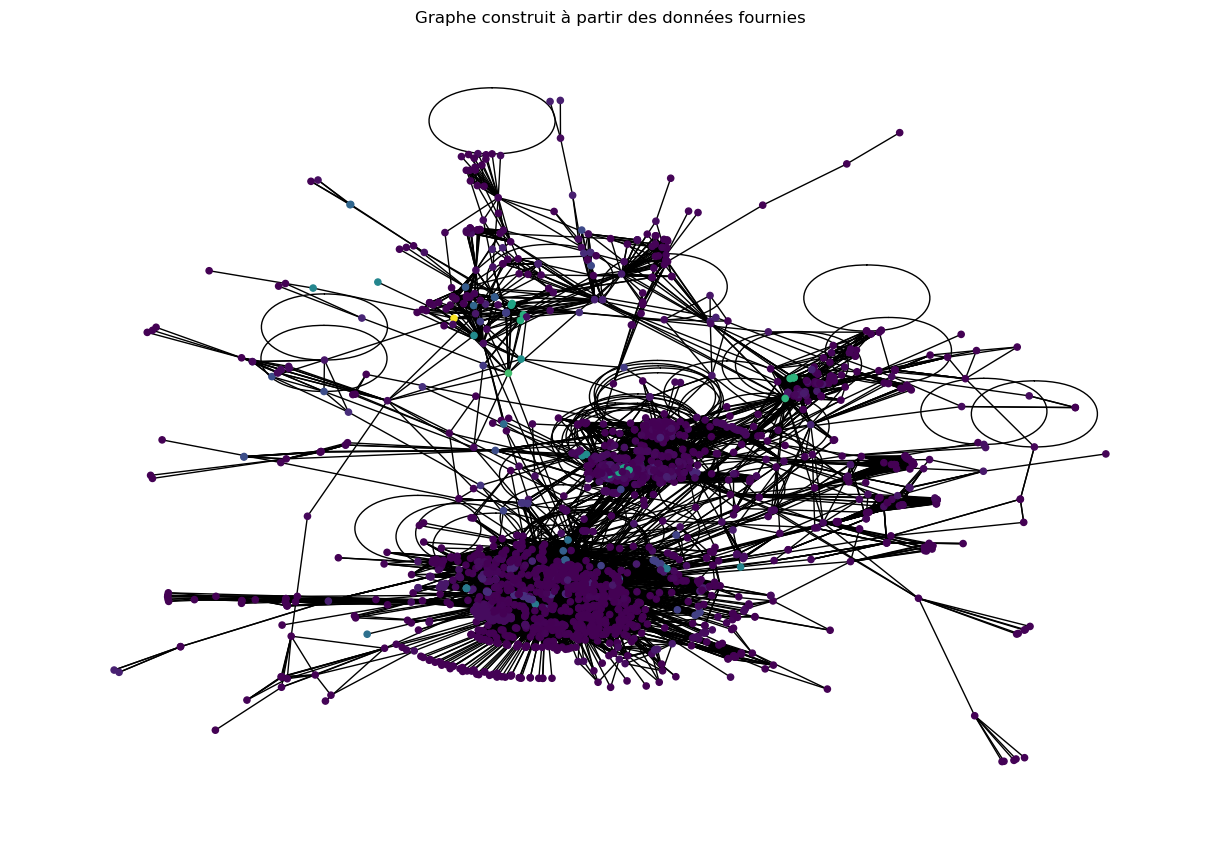

In [6]:
# Créer un graphe
G = nx.Graph()

# Ajouter les nœuds avec leurs attributs
for node, attrs in features.items():
    G.add_node(int(node), features=attrs)

# Ajouter les arêtes
for _, row in edges.iterrows():
    G.add_edge(row['id1'], row['id2'])

# Ajouter les cibles comme attributs des nœuds
for _, row in targets.iterrows():
    if int(row['id']) in G.nodes:
        G.nodes[int(row['id'])]['target'] = row['target']

# Tracer le graphe
plt.figure(figsize=(12, 8))
node_colors = [G.nodes[node].get('target', 0) for node in G.nodes]
nx.draw(
    G, 
    node_color=node_colors, 
    cmap=plt.cm.viridis, 
    node_size=20, 
    with_labels=False
)

plt.title("Graphe construit à partir des données fournies")

In [7]:
G.number_of_nodes(), G.number_of_edges()

(2277, 31421)

# Baseline : assez inutile, je voulais juste un algo qui aille vite

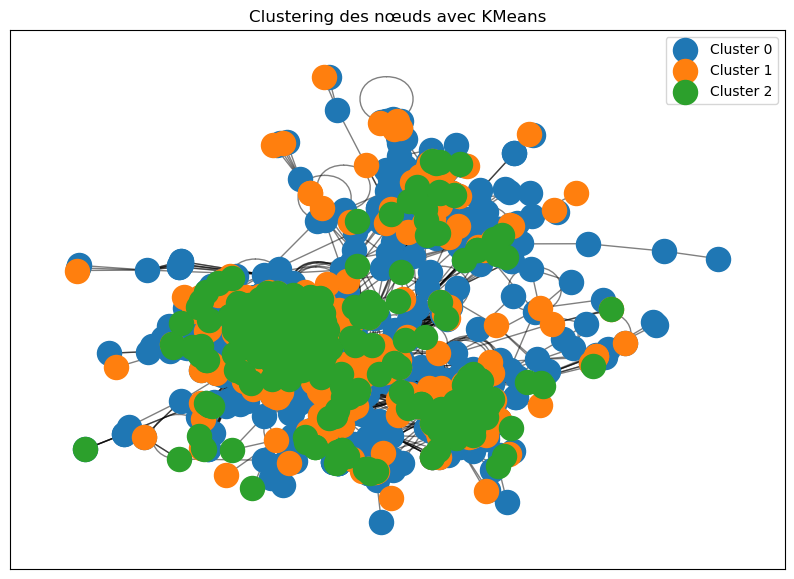

In [9]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

def graph_to_spectral_features(graph, num_features=2):
    """
    Convertit un graphe en une représentation spectrale.
    Arguments :
        graph : networkx.Graph
            Le graphe à analyser.
        num_features : int
            Nombre de composantes spectrales à conserver.
    Retourne :
        spectral_features : np.ndarray
            Une matrice où chaque ligne est une représentation spectrale d'un nœud.
    """
    # Matrice Laplacienne
    laplacian = nx.normalized_laplacian_matrix(graph).astype(float)
    
    # Calcul des vecteurs propres
    eigval, eigvec = eigs(laplacian, k=num_features, which='SM')  # 'SM' : Smallest Magnitude
    spectral_features = np.real(eigvec)  # On ne conserve que la partie réelle
    
    return spectral_features


def kmeans_on_graph(graph, num_clusters=3, num_features=2):
    """
    Applique KMeans sur les nœuds d'un graphe en utilisant une représentation spectrale.
    Arguments :
        graph : networkx.Graph
            Le graphe à analyser.
        num_clusters : int
            Nombre de clusters pour KMeans.
        num_features : int
            Nombre de composantes spectrales pour la représentation des nœuds.
    Retourne :
        labels : np.ndarray
            Un tableau contenant l'assignation de cluster pour chaque nœud.
    """
    # Étape 1 : Représentation spectrale
    spectral_features = graph_to_spectral_features(graph, num_features=num_features)
    
    # Étape 2 : KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(spectral_features)
    
    return labels


# Appliquer le clustering sur votre graphe G
num_clusters = 3  # Nombre de clusters à trouver
labels = kmeans_on_graph(G, num_clusters=num_clusters, num_features=2)

# Visualisation des résultats
pos = nx.spring_layout(G)  # Positionnement des nœuds pour la visualisation
plt.figure(figsize=(10, 7))
for cluster in range(num_clusters):
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n, l in enumerate(labels) if l == cluster],
        node_size=300,  # Ajuster la taille des nœuds
        node_color=f"C{cluster}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {cluster}"
    )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds avec KMeans")
plt.show()

# Betweeness

A réimplémnter en sortant le code custom de l'article mais qui sera le même que celui de la bibliothèque

In [ ]:
def remove_edges_with_highest_betweenness(graph,number_edges_to_compute=10, num_edges_to_remove=1000, k=500):
    """
    Supprime les `num_edges` arêtes ayant la plus grande betweeness centrality,
    tout en recalculant la centralité après chaque suppression, et retourne les clusters.
    
    Arguments :
        graph : networkx.Graph
            Le graphe sur lequel effectuer la suppression.
        num_edges : int
            Nombre d'arêtes à supprimer.
        k : int
            Paramètre pour l'approximation de la centralité.
    
    Retourne :
        modified_graph : networkx.Graph
            Le graphe après suppression des arêtes.
        clusters_numpy : np.ndarray
            Les clusters convertis en un tableau NumPy.
    """
    graph = graph.copy()  # Travaillez sur une copie pour préserver l'original
    liste_betweness = []
    # Supprimer les arêtes avec la plus grande betweeness
    for _ in tqdm(range(0,num_edges_to_remove,number_edges_to_compute), desc="Suppression des arêtes"):
        edge_betweenness = nx.edge_betweenness_centrality(graph, k=k)
        top_edges = heapq.nlargest(number_edges_to_compute,  # Nombre d'arêtes à sélectionner
            edge_betweenness.items(),  # `items()` retourne des tuples (arête, betweenness)
            key=lambda x: x[1]  # Trier par la valeur de betweenness
        )
            # Supprimer les `number_edges_to_compute` arêtes
        for edge, betweenness in top_edges:
            graph.remove_edge(*edge)
            liste_betweness.append(betweenness)


    # Extraire les clusters à partir des composantes connectées
    clusters = list(nx.connected_components(graph))
    

    return graph, clusters, liste_betweness



def visualize_clusters(graph, clusters, title="Visualisation des clusters (Matplotlib)"):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment avec Matplotlib.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        title : str
            Le titre du graphique.
    """
    pos = nx.spring_layout(graph, seed=42)  # Générer une disposition stable
    colors = plt.cm.get_cmap("tab10", len(clusters))  # Palette de couleurs pour les clusters
    
    plt.figure(figsize=(10, 7))

    # Dessiner les nœuds, colorés par cluster
    for i, cluster in enumerate(clusters):
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=list(cluster),  # Convertir l'ensemble en liste
            node_size=300,
            node_color=[colors(i)],
            label=f"Cluster {i + 1}"
        )
    
    # Dessiner les arêtes restantes
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.show()


def visualize_clusters_plotly(graph, clusters, title="Visualisation des clusters (Plotly)"):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment avec Plotly.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        title : str
            Le titre du graphique.
    """
    pos = nx.spring_layout(graph, seed=42)  # Disposition des nœuds
    edge_x = []
    edge_y = []

    # Dessiner les arêtes
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    # Dessiner les nœuds
    node_traces = []
    colors = plt.cm.get_cmap("tab10", len(clusters))
    
    for i, cluster in enumerate(clusters):
        node_x = []
        node_y = []
        for node in cluster:
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(
                size=10,
                color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                line_width=2
            ),
            name=f"Cluster {i + 1}"
        )
        node_traces.append(node_trace)
    
    # Créer la figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=True,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show(renderer="browser")


def global_modularity(clusters, G):
    """
    Calcule la modularité globale d'un graphe donné et d'un ensemble de clusters.

    Arguments :
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        G : networkx.Graph
            Le graphe pour lequel calculer la modularité.

    Retourne :
        Q : float
            La modularité globale du graphe pour les clusters donnés.
    """
    m = G.number_of_edges()  # Nombre total d'arêtes
    if m == 0:
        raise ValueError("Le graphe ne contient aucune arête, la modularité ne peut pas être calculée.")

    # Initialiser la modularité
    Q = 0

    # Itérer sur chaque cluster
    for cluster in clusters:
        # Convertir le cluster en liste (au cas où il serait un set)
        cluster_nodes = list(cluster)

        # Sous-graphe correspondant au cluster
        subgraph = G.subgraph(cluster_nodes)

        # Calculer les termes de la modularité pour ce cluster
        L_c = subgraph.number_of_edges()  # Arêtes à l'intérieur du cluster
        k_c = sum(G.degree(n) for n in cluster_nodes)  # Somme des degrés des nœuds du cluster

        # Contribution à la modularité
        Q += (L_c / m) - (k_c / (2 * m)) ** 2

    return Q

In [ ]:
G2,clusters,betwenness = remove_edges_with_highest_betweenness(G,number_edges_to_compute=5, num_edges_to_remove=400, k=None)
# Visualiser les clusters
visualize_clusters(G2, clusters)
visualize_clusters(G, clusters)
visualize_clusters_plotly(G, clusters)

plt.figure(figsize=(10, 6))
plt.plot(betwenness)

Suppression des arêtes:  38%|███▊      | 30/80 [29:21<42:58, 51.57s/it]  

In [ ]:
for cluster in clusters:
    print(f"Cluster de taille {len(cluster)} : {cluster}")

print(f"Modularité globale : {global_modularity(clusters, G):.3f}")

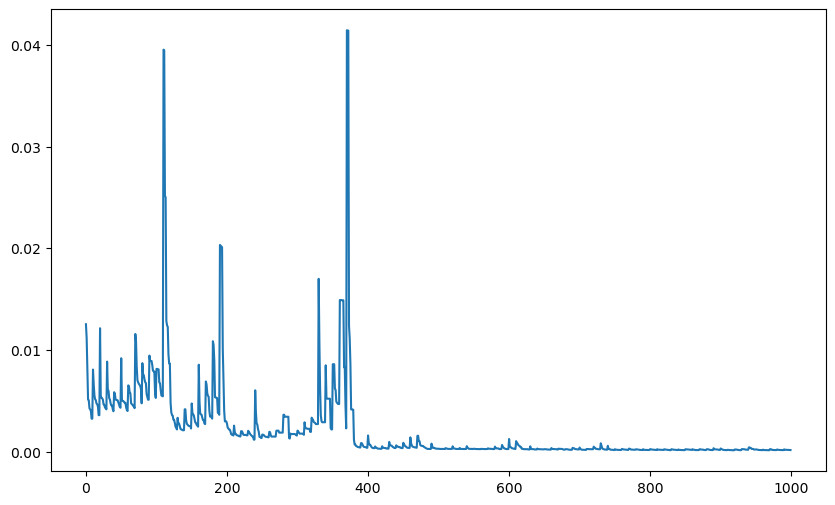

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(betwenness)

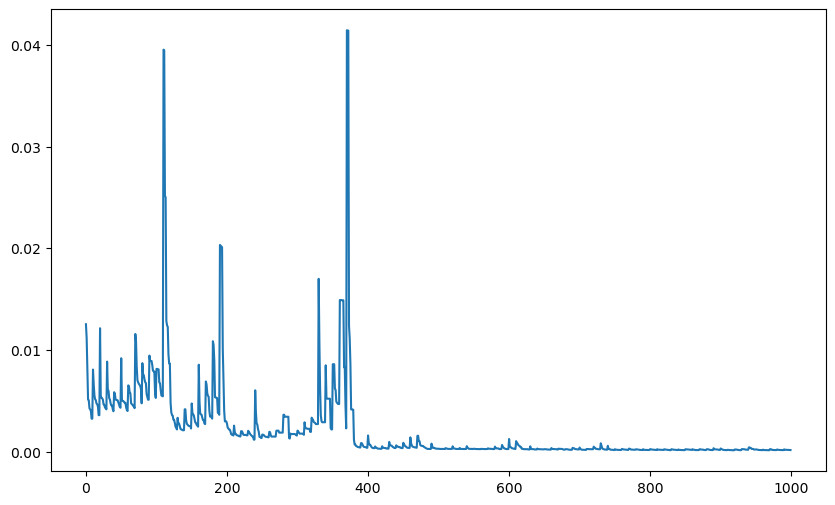

In [ ]:
#Quand j'avais run sur beaucoup tous les 10
len(clusters)
plt.figure(figsize=(10, 6))
plt.plot(betwenness)

In [14]:
dictionary_clusters={}
for i in range(len(clusters)):
    liste=[]
    for j in clusters[i]:
        liste.append(names[0][j])
    dictionary_clusters[i] = liste


219
Cluster 0 : diutinum american mimeomyces related hormel zameen reist ralph travi 1098 du champagne test 1016 dal...


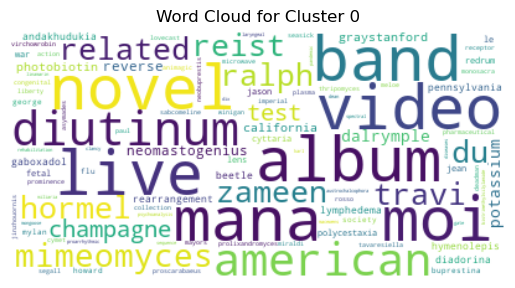

1866
Cluster 1 : 906 melobasina 496 phospholipase 2047 gyascutus star karenaxia 366 seaworld 1264 nanowires 679 vulca...


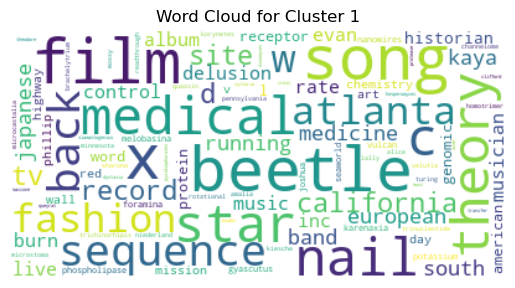

139
Cluster 2 : american 488 autarcontes island kaler tenericutes 799 loob lady 780 cobosesta 90 1479 steven hypohid...


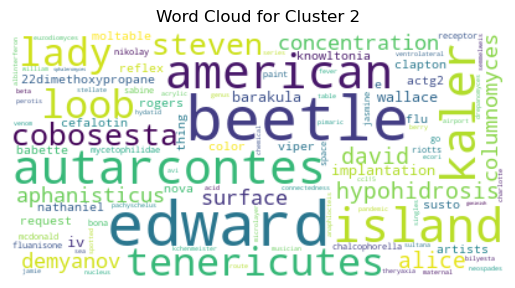

36
Cluster 3 : histeridomyces laputa route xinlisupreme syndrome 1940 phalacridae band laboulbeniales 251 sugiyamae...


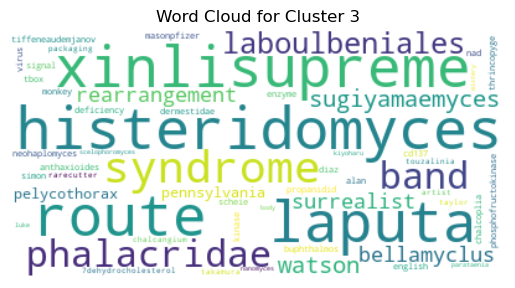

14
Cluster 4 : cherrybomb trim28 film 460 1628 chrysobothris histone 344 1830 2015 robin cotton 140 herbert werthei...


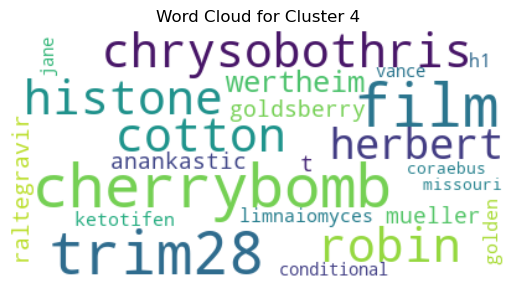

3
Cluster 5 : ovotransferrin vue eola 219 at americaneast the 1141 lake 1790...


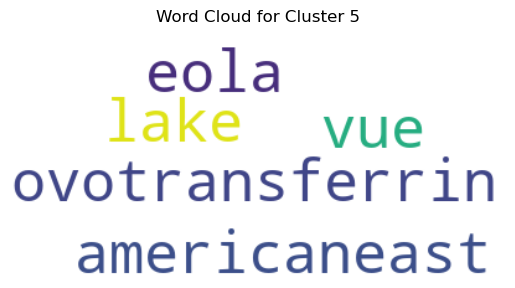

In [ ]:


# Créez un Word Cloud pour chaque cluster
for cluster_id, cluster_phrases in dictionary_clusters.items():
    # Combinez toutes les phrases du cluster
    print(len(cluster_phrases))
    text = ' '.join(cluster_phrases).lower()
    text = ' '.join(set(text.split()))
    text = re.sub(r'[^\w\s]', '', text)  # Supprime les caractères non alphanumériques
    text = text.lower()
    print(f"Cluster {cluster_id} : {text[:100]}...")
    # Générez le Word Cloud
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    # Affichez le Word Cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

# On essaye sur les caméléons et les croco

In [23]:
# Définir le chemin de base
base_path = Path('Dataset') / 'wikipedia' / 'chameleon'

# Charger les données
with (base_path / 'musae_chameleon_features.json').open('r') as f:
    features_chameleon = json.load(f)

edges_chameleon = pd.read_csv(base_path / 'musae_chameleon_edges.csv')
targets_chameleon = pd.read_csv(base_path / 'musae_chameleon_target.csv')

names = pd.read_csv('data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

In [20]:
# Définir le chemin de base
base_path = Path('Dataset') / 'wikipedia' / 'crocodile'

# Charger les données
with (base_path / 'musae_crocodile_features.json').open('r') as f:
    features_croco = json.load(f)

edges_croco = pd.read_csv(base_path / 'musae_crocodile_edges.csv')
targets_croco = pd.read_csv(base_path / 'musae_crocodile_target.csv')


In [24]:
edges = pd.concat([edges_chameleon, edges_croco])
targets = pd.concat([targets_chameleon, targets_croco])
features = {**features_chameleon, **features_croco}

Ajout des nœuds avec attributs: 100%|██████████| 11631/11631 [00:00<00:00, 612694.35it/s]
Ajout des arêtes: 216121it [00:05, 38545.24it/s]
Ajout des cibles aux nœuds: 13908it [00:00, 38033.70it/s]


Text(0.5, 1.0, 'Graphe construit à partir des données fournies')

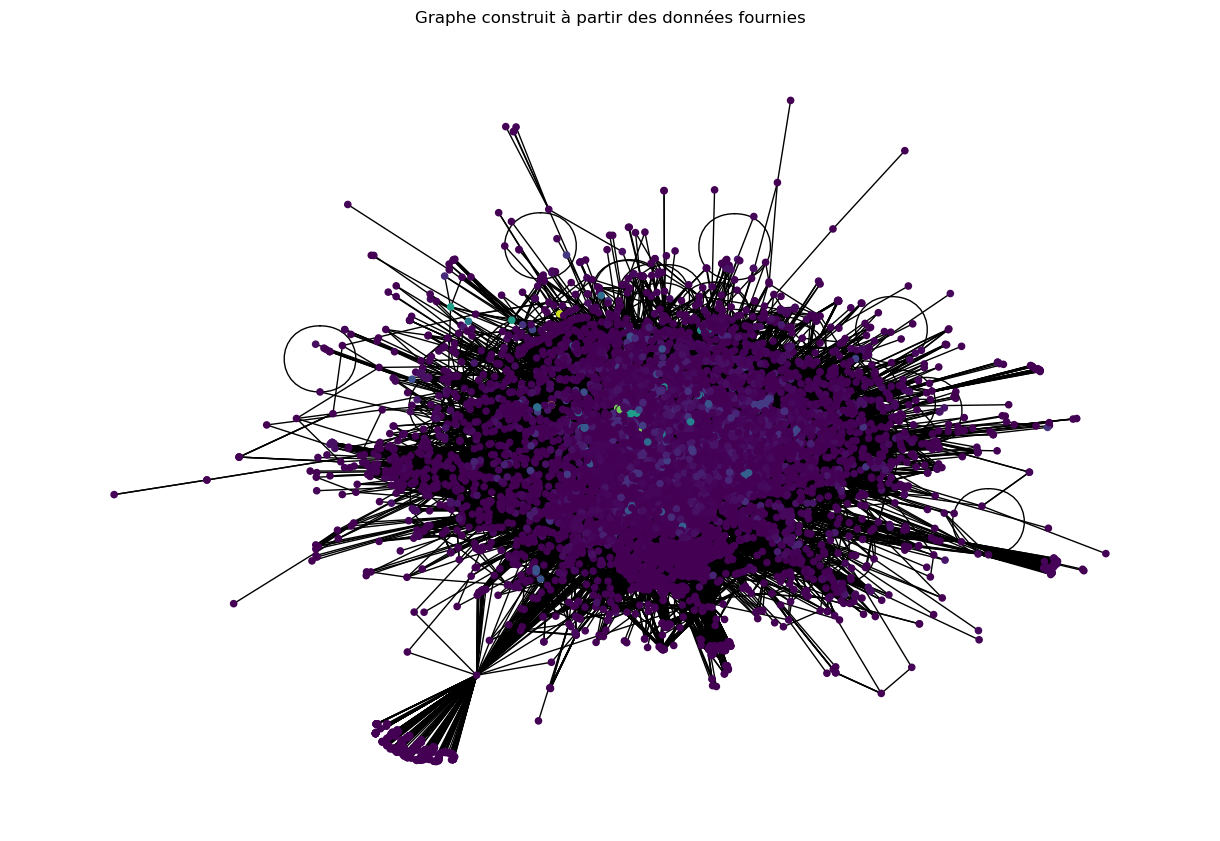

In [27]:
# Créer un graphe
G = nx.Graph()

# Ajouter les nœuds avec leurs attributs
for node, attrs in tqdm(features.items(),desc="Ajout des nœuds avec attributs"):
    G.add_node(int(node), features=attrs)

# Ajouter les arêtes
for _, row in tqdm(edges.iterrows(), desc="Ajout des arêtes"):
    G.add_edge(row['id1'], row['id2'])

# Ajouter les cibles comme attributs des nœuds
for _, row in tqdm(targets.iterrows(), desc="Ajout des cibles aux nœuds"):
    if int(row['id']) in G.nodes:
        G.nodes[int(row['id'])]['target'] = row['target']

# Tracer le graphe
plt.figure(figsize=(12, 8))
node_colors = [G.nodes[node].get('target', 0) for node in G.nodes]
nx.draw(
    G, 
    node_color=node_colors, 
    cmap=plt.cm.viridis, 
    node_size=20, 
    with_labels=False
)

plt.title("Graphe construit à partir des données fournies")

In [28]:
G.number_of_nodes(), G.number_of_edges()

(11631, 202309)

Suppression des arêtes: 100%|██████████| 150/150 [2:34:59<00:00, 62.00s/it] 
C:\Users\antoi\AppData\Local\Temp\ipykernel_29512\3026822006.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(clusters_numpy))  # Palette de couleurs pour les clusters


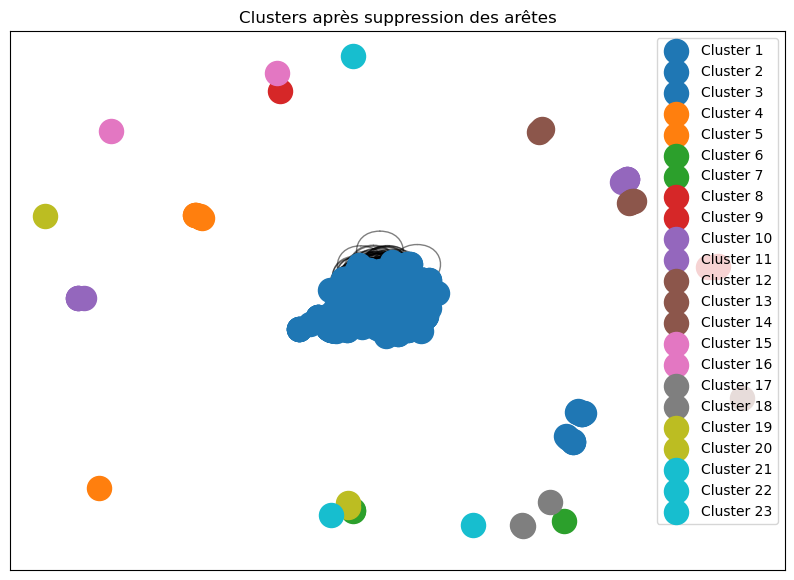

In [32]:
G2,clusters = remove_edges_with_highest_betweenness(G,num_edges=150, k=300)
# Visualiser les clusters
visualize_clusters(G2, clusters)

In [33]:
dictionary_clusters={}
for i in range(len(clusters)):
    liste=[]
    for j in clusters[i]:
        liste.append(names[0][j])
    dictionary_clusters[i] = liste

11573
Cluster 0 : duranii poverty 366 fracture 11330 fibers du bendroflumethiazide a1 mastication nitrogenous 983 feli...


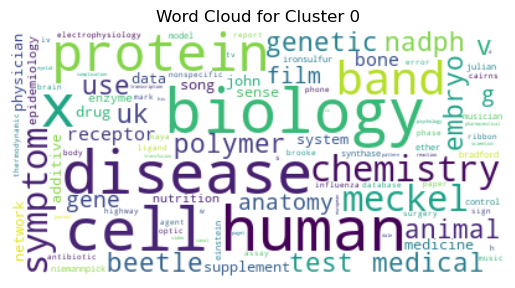

6
Cluster 1 : genomics 8850 10639 exenatide aqueous procainamide nutritional nerve 5287 10737 nortriptyline 6094 s...


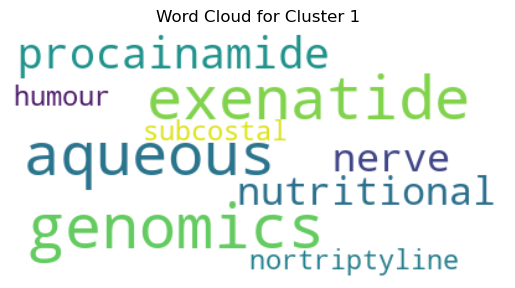

9
Cluster 2 : nfat5 6105 10426 heavy 8312 pseudoporphyria 9829 immunoglobulin human 9471 amiodarone degasification...


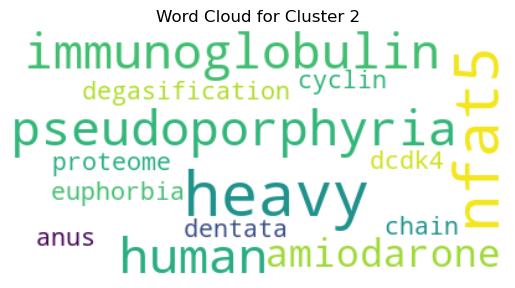

7
Cluster 3 : john acute 10410 elasticum 2477 junction carbohydrate abelson syndrome 5297 5ht1a eye 8862 9428 asti...


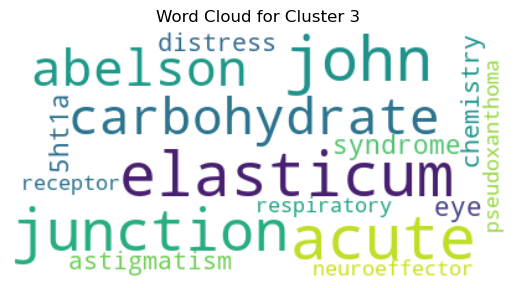

1
Cluster 4 : 10632 diabetes latent autoimmune...


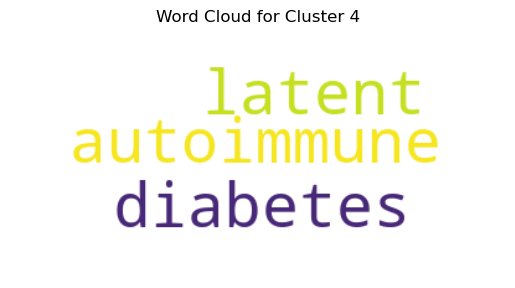

1
Cluster 5 : diabetes heart and institute baker idi 4841...


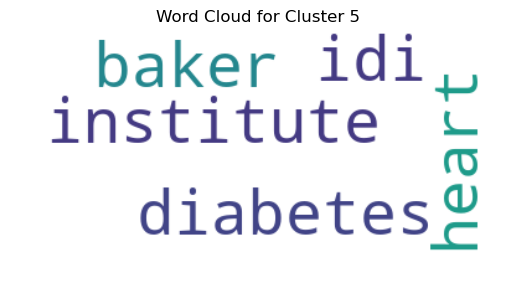

2
Cluster 6 : 9627 6603 gracilicutes dermatitis...


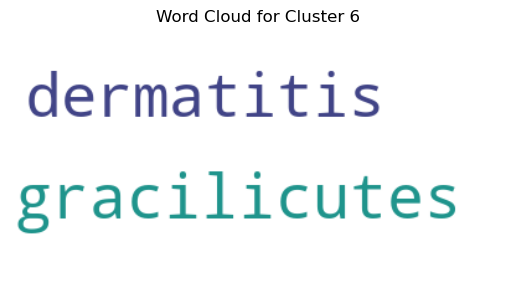

1
Cluster 7 : cellulose 7947 carboxymethyl...


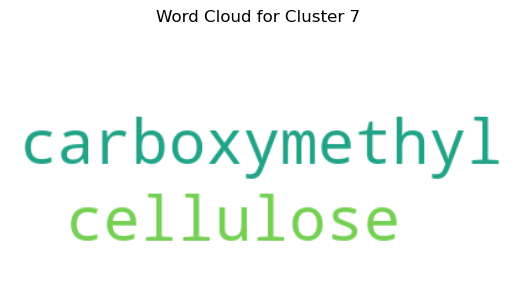

4
Cluster 8 : transmitted microbicides 3158 receptor dietary 8310 h2 diseases histamine psychophysics for roughnes...


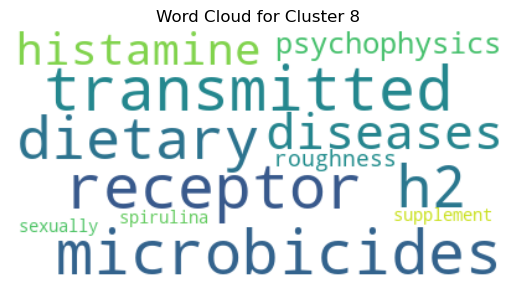

4
Cluster 9 : list mesh 10784 codes 2917 stickler 4823 hyoglossus 10822 of a16 syndrome c21...


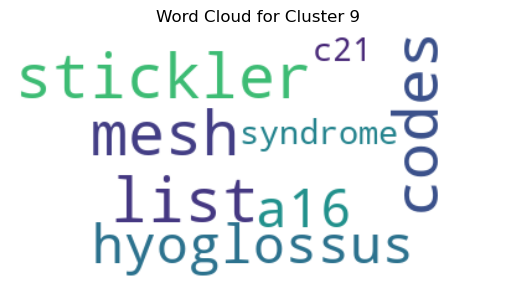

5
Cluster 10 : dystonia acidophiles in acid xxxx 7536 10997 8340 dopamineresponsive furfural 48 10982 drainage 8460...


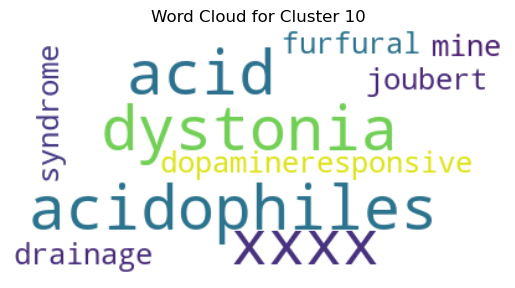

4
Cluster 11 : mutase motion methylmalonylcoa nitrate sodium 6789 nitroprusside sickness 9104 3393 7701...


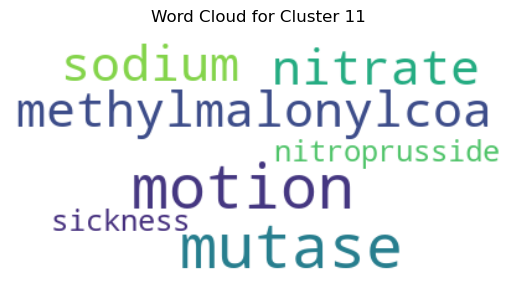

2
Cluster 12 : rna polymerase 11010 ii acids 8622 chloroacetic...


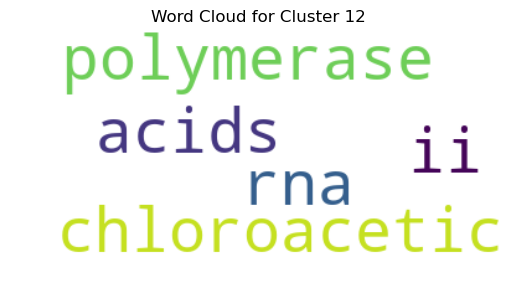

1
Cluster 13 : 5217 biological pacemaker...


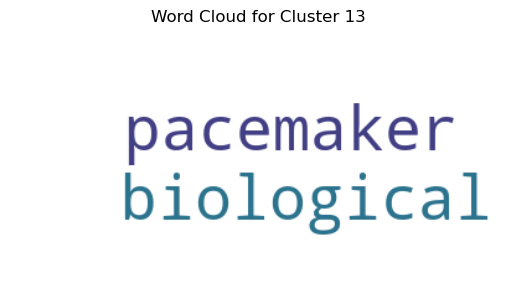

1
Cluster 14 : edingerwestphal nucleus 4868...


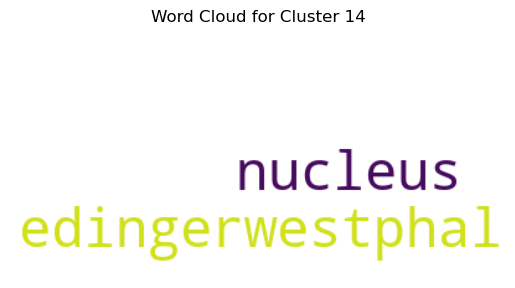

1
Cluster 15 : neuritis optic 5353...


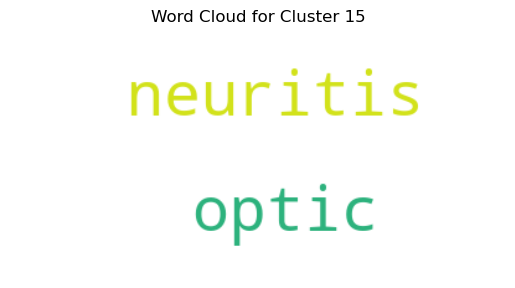

1
Cluster 16 : 11370 nicholas culpeper...


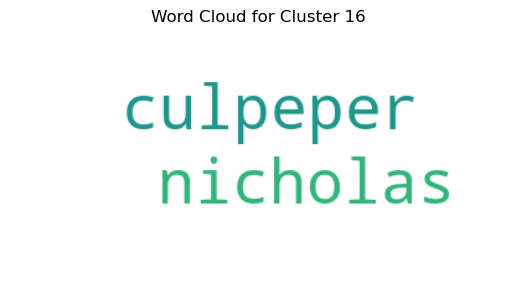

2
Cluster 17 : 6400 il1a dehydrogenase 11betahydroxysteroid 4518...


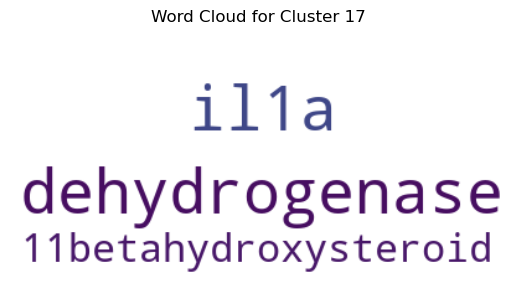

2
Cluster 18 : vagina international 3443 society oncology paediatric of 8307...


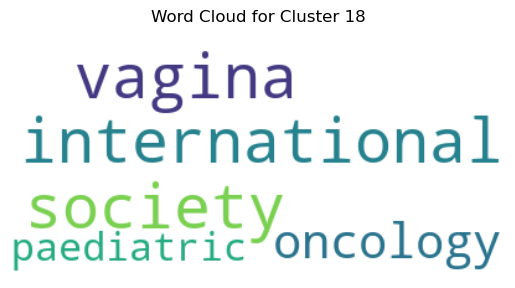

1
Cluster 19 : trimethylsilyl 7460 chloride...


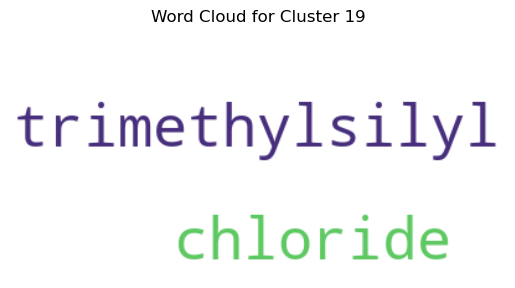

1
Cluster 20 : 6825 tests function liver...


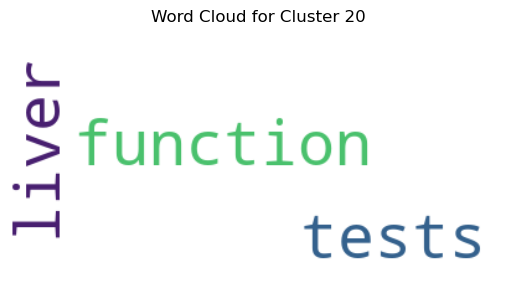

1
Cluster 21 : 7841 sulfide...


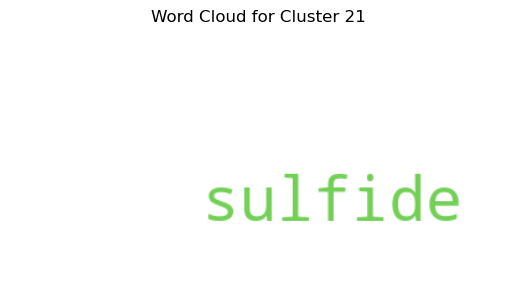

1
Cluster 22 : 7949 cucurbituril...


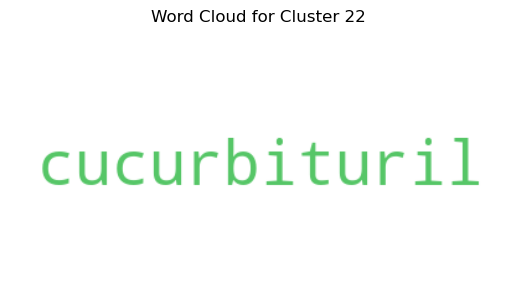

In [34]:

# Créez un Word Cloud pour chaque cluster
for cluster_id, cluster_phrases in dictionary_clusters.items():
    # Combinez toutes les phrases du cluster
    print(len(cluster_phrases))
    text = ' '.join(cluster_phrases).lower()
    text = ' '.join(set(text.split()))
    text = re.sub(r'[^\w\s]', '', text)  # Supprime les caractères non alphanumériques
    text = text.lower()
    print(f"Cluster {cluster_id} : {text[:100]}...")
    # Générez le Word Cloud
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    # Affichez le Word Cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

# Sur le dataset géant

Nombre de nœuds : 1791489
Nombre d'arêtes : 25447873


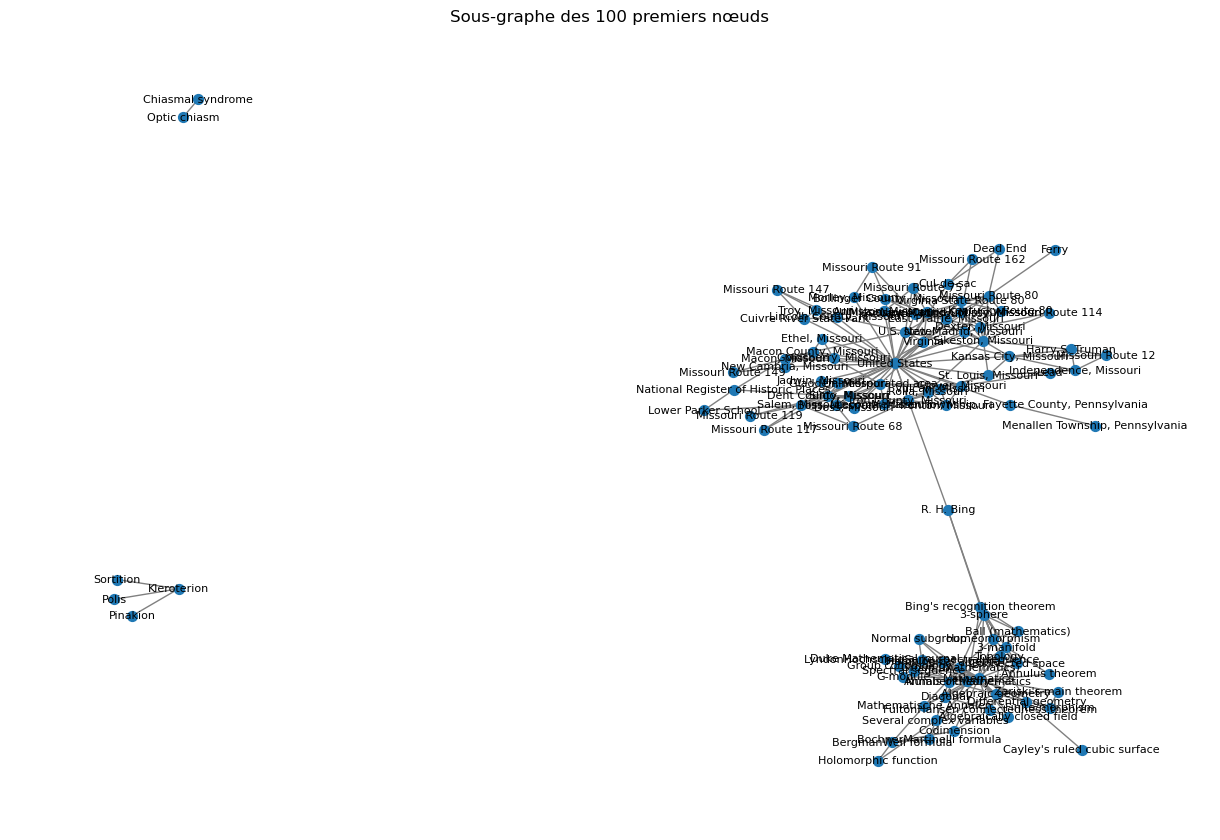

In [4]:
import gzip


# Charger les arêtes du graphe
def load_edges(file_path):
    edges = []
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return edges

# Charger les noms des pages
def load_page_names(file_path):
    page_names = {}
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            line = line.strip()
            if not line:  # Ignorer les lignes vides
                continue
            parts = line.split(' ', 1)
            if len(parts) == 2:  # Vérifier que la ligne contient bien deux parties
                page_id, page_name = parts
                page_names[int(page_id)] = page_name
    return page_names

# Chemins vers les fichiers
base_path = "data/big_graph"
edges_file = f"{base_path}/wiki-topcats.txt.gz"
page_names_file = f"{base_path}/wiki-topcats-page-names.txt.gz"

# Charger les données
edges = load_edges(edges_file)
page_names = load_page_names(page_names_file)

# Créer le graphe
G = nx.Graph()
G.add_edges_from(edges)  # Ajouter les arêtes

# Ajouter les noms des pages comme attributs des nœuds
nx.set_node_attributes(G, page_names, "name")

# Informations sur le graphe
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")

# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:100])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation
plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 100 premiers nœuds")
plt.show()

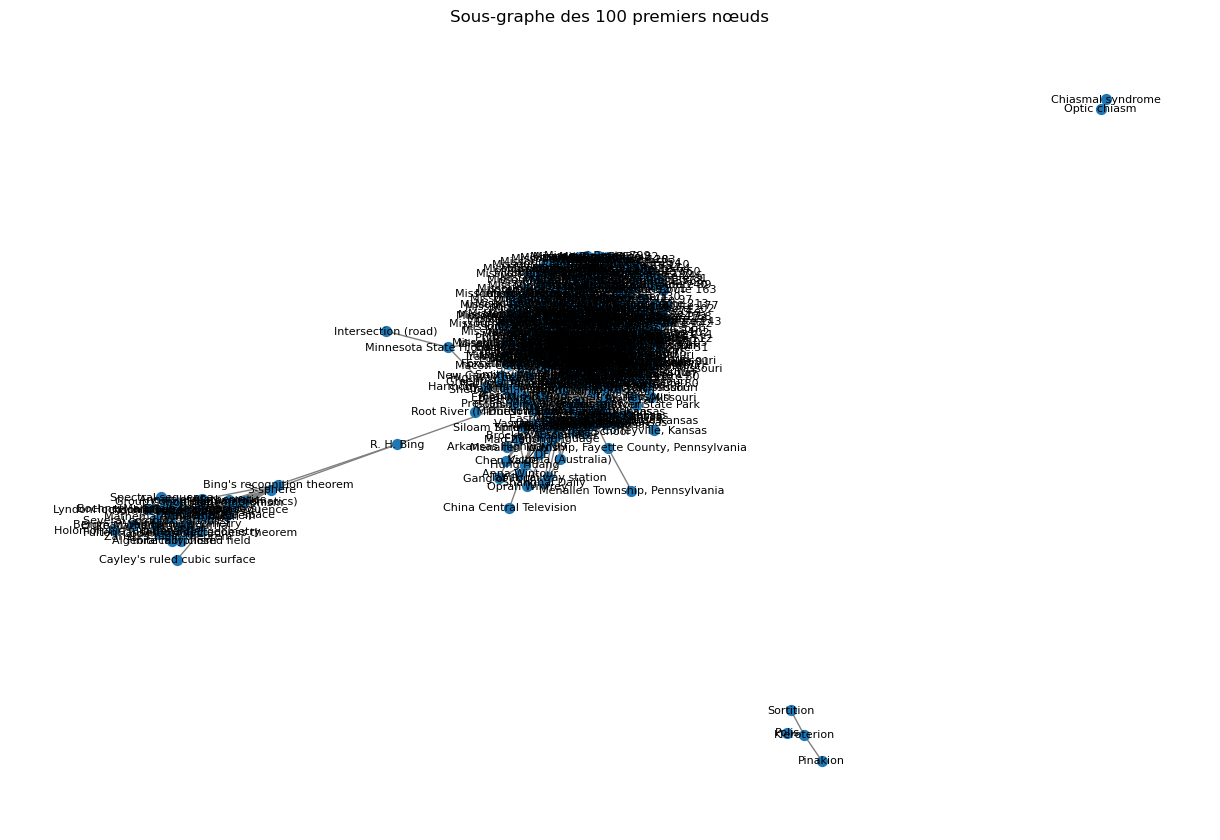

In [39]:
# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:400])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation
plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 100 premiers nœuds")
plt.show()

In [7]:
import networkx as nx
import plotly.graph_objects as go

# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:1000])  # Prenez un sous-graphe avec 400 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation

# Préparer les nœuds
node_x = []
node_y = []
node_text = []

for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_text.append(G.nodes[node].get("name", f"Node {node}"))  # Infobulle pour chaque nœud

# Préparer les arêtes
edge_x = []
edge_y = []

for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # None pour interrompre la ligne
    edge_y.extend([y0, y1, None])

# Créer le tracé des arêtes
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo="none",
    mode="lines"
)

# Créer le tracé des nœuds
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    marker=dict(
        size=10,
        color="#1f78b4",
        line_width=2
    ),
    text=node_text,
    hoverinfo="text"
)

# Créer la figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Sous-graphe interactif",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode="closest",
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False),
                ))

fig.show(renderer="browser")

In [5]:
G2,clusters = remove_edges_with_highest_betweenness(G,num_edges=10, k=4)


Suppression des arêtes:  30%|███       | 3/10 [2:31:00<5:52:20, 3020.11s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\antoi\anaconda3\envs\PGM\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\antoi\AppData\Local\Temp\ipykernel_13548\2121361890.py", line 1, in <module>
    G2,clusters = remove_edges_with_highest_betweenness(G,num_edges=10, k=4)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\antoi\AppData\Local\Temp\ipykernel_13548\3026822006.py", line 24, in remove_edges_with_highest_betweenness
    edge_betweenness = nx.edge_betweenness_centrality(graph, k=k)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 12", line 4, in argmap_edge_betweenness_centrality_9
    import inspect
            ^^^^^^^
  File "c:\Users\antoi\anaconda3\envs\PGM\Lib\site-packages\networkx\utils\backends.py", line 412, in __call__
    return self.orig_fu

In [ ]:
# Visualiser les clusters
visualize_clusters(G2, clusters)

In [49]:
import nbformat
print(nbformat.__version__)

5.10.4


# Bonus

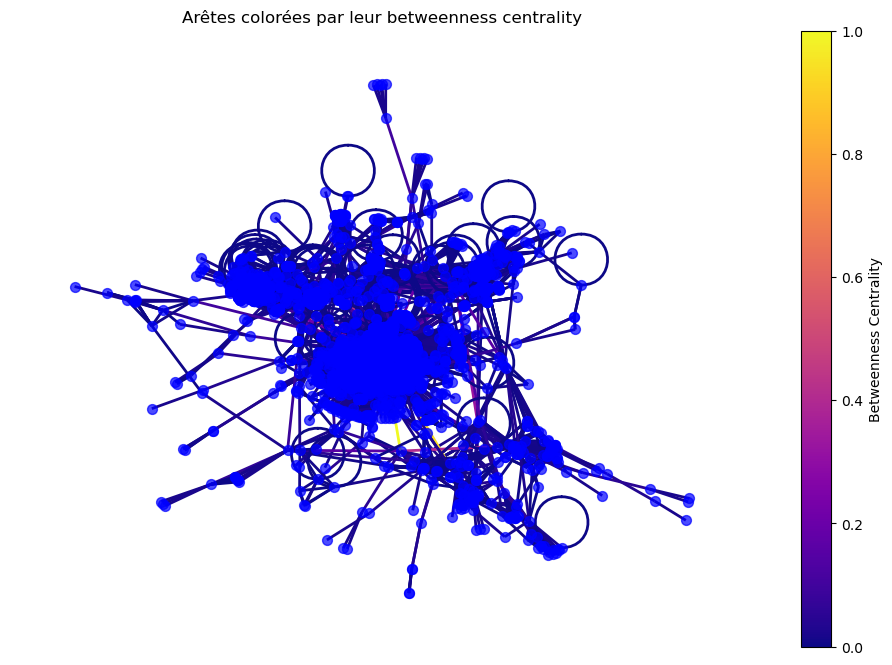

In [ ]:
# test de l'approche betweeness sur un graphe


# Calcul de la betweenness centrality pour chaque arête
edge_betweenness = edge_betweenness_centrality(G)

# Normaliser les valeurs de betweenness pour la visualisation
max_betweenness = max(edge_betweenness.values()) if edge_betweenness else 1
edge_colors = [edge_betweenness[edge] / max_betweenness for edge in G.edges]

# Créer une figure et des axes explicites
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G)  # Calculer les positions des nœuds pour le tracé

# Tracer les nœuds
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color="blue", alpha=0.7)

# Tracer les arêtes avec des couleurs selon leur betweenness
edges = nx.draw_networkx_edges(
    G, pos, ax=ax, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=2
)

# Ajouter une colorbar en explicitant l'axe
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Betweenness Centrality")

# Ajouter un titre et finaliser
ax.set_title("Arêtes colorées par leur betweenness centrality")
ax.axis("off")
plt.show()

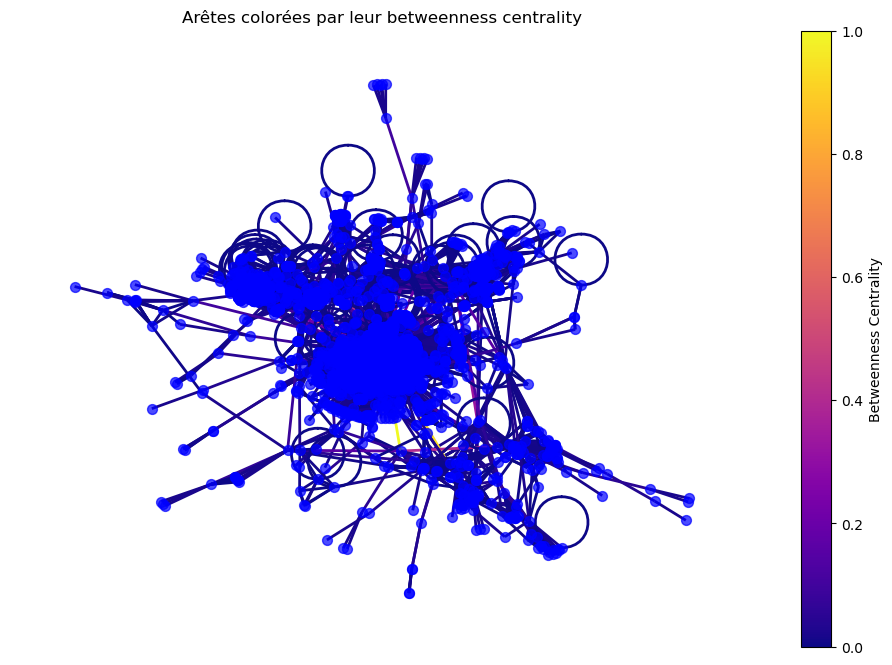

In [ ]:
# test de l'approche betweeness sur un graphe


# Calcul de la betweenness centrality pour chaque arête
edge_betweenness = edge_betweenness_centrality(G)

# Normaliser les valeurs de betweenness pour la visualisation
max_betweenness = max(edge_betweenness.values()) if edge_betweenness else 1
edge_colors = [edge_betweenness[edge] / max_betweenness for edge in G.edges]

# Créer une figure et des axes explicites
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G)  # Calculer les positions des nœuds pour le tracé

# Tracer les nœuds
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color="blue", alpha=0.7)

# Tracer les arêtes avec des couleurs selon leur betweenness
edges = nx.draw_networkx_edges(
    G, pos, ax=ax, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=2
)

# Ajouter une colorbar en explicitant l'axe
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Betweenness Centrality")

# Ajouter un titre et finaliser
ax.set_title("Arêtes colorées par leur betweenness centrality")
ax.axis("off")
plt.show()